# IV. Camera Calibration

TODO: ask about normalisation (3D)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation

from lib import hest, CrossOp, normalize2d

## Direct linear transform

In [2]:
Q = np.array([
    [0, 0, 0, 0, 1, 1, 1, 1],
    [0, 0, 1, 1, 0, 0, 1, 1],
    [0, 1, 0, 1, 0, 1, 0, 1],
    np.ones(8)
])

f = 1000
h, w = 1080, 1920

K = np.array([
    [f, 0, w / 2],
    [0, f, h / 2],
    [0, 0, 1    ],
])

R = np.array([
    [np.sqrt(0.5), -np.sqrt(0.5), 0],
    [np.sqrt(0.5),  np.sqrt(0.5), 0],
    [0           ,  0           , 1],
])
t = np.array([0, 0, 10]).reshape(3, 1)

### 1. Projection

In [3]:
# Projection matrix
T = np.hstack([R, t])
P = K @ T
P.astype(int)

array([[ 707, -707,  960, 9600],
       [ 707,  707,  540, 5400],
       [   0,    0,    1,   10]])

In [4]:
# projections
q = P @ Q
q = q / q[2]
q.astype(int)

array([[ 960,  960,  889,  895, 1030, 1024,  960,  960],
       [ 540,  540,  610,  604,  610,  604,  681,  668],
       [   1,    1,    1,    1,    1,    1,    1,    1]])

### 2. Estimation of the projection matrix from the points with DLT

In [5]:
def DLT(Q, q, normalize=True):
    """Return the projection matrix P such that q = P @ Q.
    
    Parameters
    ----------
    Q, q: numpy arrays
        Homogeneous points before and after the projection: q = PQ.
    """
    _, n = Q.shape
    if normalize:
#         TQ, Q = normalize2d(Q)
        Tq, q = normalize2d(q)

    B = np.zeros((3 * n, 12))
    for i in range(n):
        B[3 * i: 3 * i + 3] = np.kron(Q[:, i], CrossOp(q[:, i]))
    u, s, vh = np.linalg.svd(B)
    P = vh[-1]
    P = P.reshape(4, 3).T
    
    if normalize:
        P = np.linalg.inv(Tq) @ P #@ TQ
    
    return P/P[-1, -1]

In [6]:
P = DLT(Q, q)
np.round(P * 10, 2)

array([[ 7.0711e+02, -7.0711e+02,  9.6000e+02,  9.6000e+03],
       [ 7.0711e+02,  7.0711e+02,  5.4000e+02,  5.4000e+03],
       [-0.0000e+00,  0.0000e+00,  1.0000e+00,  1.0000e+01]])

In [7]:
P = DLT(Q, q, normalize=False)
q2 = P @ Q
q2 = q2 / q2[2]
projection_error = np.linalg.norm(q - q2)
projection_error

6.588450728461687e-10

In [8]:
P = DLT(Q, q, normalize=True)
q2 = P @ Q
q2 = q2 / q2[2]
projection_error = np.linalg.norm(q - q2)
projection_error

1.9691137908567693e-13

The absolute projection error diminishes with normalisation

## Checkerboard calibration

### 3. Checkboards points

In [9]:
def checkerboard_points(n, m):
    """Return the inhomogeneous 3D points of a checkerboard."""
    return np.array([
        [i - (n - 1) / 2 for i in range(n) for j in range(m)],
        [j - (m - 1) / 2 for i in range(n) for j in range(m)],
        np.zeros(n * m),
    ])

In [10]:
checkerboard_points(3, 3)

array([[-1., -1., -1.,  0.,  0.,  0.,  1.,  1.,  1.],
       [-1.,  0.,  1., -1.,  0.,  1., -1.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

### 4. Moved points

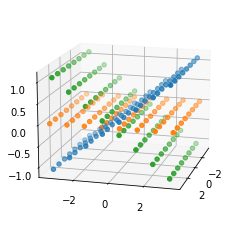

In [11]:
n, m = 8, 8
Q_omega = checkerboard_points(n, m)

R_a = Rotation.from_euler('xyz', [np.pi / 10, 0, 0]).as_matrix()
R_c = Rotation.from_euler('xyz', [- np.pi / 10, 0, 0]).as_matrix()

Q_a = np.vstack((
    R_a @ Q_omega,
    np.ones(n * m)
))
Q_b = np.vstack((
    Q_omega,
    np.ones(n * m)
))
Q_c = np.vstack((
    R_c @ Q_omega,
    np.ones(n * m)
))

Q_omega = np.vstack((
    Q_omega,
    np.ones(n * m)
))


fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(Q_a[0], Q_a[1], Q_a[2])
ax.scatter(Q_b[0], Q_b[1], Q_b[2])
ax.scatter(Q_c[0], Q_c[1], Q_c[2])
ax.view_init(15, 15)

In [12]:
q_a = P @ Q_a
q_b = P @ Q_b
q_c = P @ Q_c
qs = [q_a, q_b, q_c]

## Zhang's method

### 5. Estimation of homograpies

In [13]:
def estimateHomographies(Q_omega, qs):
    """Return homographies that map from Q_omega to each of the entries in qs.
    
    Parameters
    ----------
    Q_omega: numpy array
        original un-transformed checkerboard points in 3D.
    qs: list of arrays
        each element in the list containing Q Ω projected to the image
        plane from different views.
    
    Return
    ------
    list of 3 x 3 arrays
        homographies
        
    """
    m = [0, 1, 3]
    return [hest(Q_omega[m, :], qs[i]) for i in range(len(qs))]

In [14]:
Hs = estimateHomographies(Q_omega, qs)
H_a, H_b, H_c = Hs

We can check that the homograpies are correct:

In [15]:
tilde = [0, 1, 3]
a = (np.round(H_a @ Q_omega[tilde] - q_a, 12) == 0).all()
b = (np.round(H_b @ Q_omega[tilde] - q_b, 12) == 0).all()
c = (np.round(H_c @ Q_omega[tilde] - q_c, 12) == 0).all()
a, b, c

(True, True, True)

### 6. Estimation of $\mathit{b}$

In [16]:
def estimate_b(Hs):
    """Return the estimate of the b matrix.
    
    Parameters
    ----------
    Hs: list of 3 x 3 arrays
        homographies
    """
    n = len(Hs)
    V = np.zeros((2 * n, 6))

    for i in range(n):
        V[2 * i: 2 * i + 2] = np.array([
            get_v(0, 1, Hs[i]),
            get_v(0, 0, Hs[i]) - get_v(1, 1, Hs[i])
        ])
    u, s, vh = np.linalg.svd(V)
    b = vh[-1]
    return b
    

def get_v(alpha, beta, H):
    return np.array([
        H[0, alpha] * H[0, beta],
        H[0, alpha] * H[1, beta] + H[1, alpha] * H[0, beta],
        H[1, alpha] * H[1, beta],
        H[2, alpha] * H[0, beta] + H[0, alpha] * H[2, beta],
        H[2, alpha] * H[1, beta] + H[1, alpha] * H[2, beta],
        H[2, alpha] * H[2, beta],
    ])

Let us check that we get the same result with $\textbf{B}_{true} = \textbf{K}^{-T}\textbf{K}^{-1}$

In [17]:
B_true = np.linalg.inv(K).T @ np.linalg.inv(K)
b_true = [
    B_true[0, 0],
    B_true[0, 1],
    B_true[1, 1],
    B_true[0, 2],
    B_true[1, 2],
    B_true[2, 2]
]
b_true/b_true[-1] - estimate_b([H_a, H_b, H_c])

array([ 5.59552717e-14, -5.45121710e-22,  5.59552737e-14, -5.37170695e-11,
       -3.02158408e-11,  1.23840221e-07])

B is symmetric. Therefore:

In [18]:
b = estimate_b([H_a, H_b, H_c])
B = np.array([
    [b[0], b[1], b[3]],
    [b[1], b[2], b[4]],
    [b[3], b[4], b[5]],
])

### 7. Estimation of the camera matrix

In [19]:
def estimateIntrinsics(Hs):
    """Return the camera matrix given a list of homographies.
    
    Parameters
    ----------
    Hs: list of 3 x 3 numpy arrays
        homographies

    Return
    ------
    A: 3 x 3 numpy array
        Camera matrix
    """
    b = estimate_b(Hs)
#     B = np.array([
#         [b[0], b[1], b[3]],
#         [b[1], b[2], b[4]],
#         [b[3], b[4], b[5]],
#     ])

    term1 = b[1] * b[3] - b[0] * b[4]
    term2 = b[0] * b[2] - b[1] ** 2

    v0 = term1 / term2
    lambda_ = b[5] - (b[3] ** 2 + v0 * term1) / b[0]
    alpha = np.sqrt(lambda_ / b[0])
    beta = np.sqrt(lambda_ * b[0] / term2)
    gamma = -b[1] * alpha ** 2 * beta / lambda_
    u0 = gamma * v0 / beta - b[3] * alpha ** 2 / lambda_
    
    A = np.array([
        [alpha, gamma, u0],
        [0    , beta , v0],
        [0    , 0    , 1 ],
    ])
    return A

In [20]:
np.rint(estimateIntrinsics(Hs * 10))

array([[1000.,   -0.,  960.],
       [   0., 1000.,  540.],
       [   0.,    0.,    1.]])

### 8. Full camera calibration

In [21]:
def estimateExtrinsics(K, Hs):
    """Return the extrinsic parameters of the camera."""
    Rs = []
    ts = []
    for H in Hs:
        lambda_ = 1 / np.linalg.norm(np.linalg.inv(K) @ H[:, 0])
        r0 = lambda_ * np.linalg.inv(K) @ H[:, 0]
        r1 = lambda_ * np.linalg.inv(K) @ H[:, 1]
        t  = lambda_ * np.linalg.inv(K) @ H[:, 2]

        Rs.append(np.vstack((r0, r1, np.cross(r0, r1))).T)
        ts.append(t)
    return Rs, ts

def calibrateCamera(qs, Q):
    """Return the intrisic and extrinsic parameters of a camera.
    
    Based on several view of a set of points.
    
    Parameters
    ----------
    qs: list of arrays
        each element in the list containing Q projected to the image
        plane from different views.
    Q: numpy array
        original un-transformed checkerboard points in 3D.
    """
    Hs = estimateHomographies(Q_omega=Q, qs=qs)
    K = estimateIntrinsics(Hs)
    Rs, ts = estimateExtrinsics(K, Hs)
    return K, Rs, ts

In [22]:
K, Rs, ts = calibrateCamera(qs, Q_omega)

In [23]:
print(np.round(R_a, 2))
print(np.round(Rs[0], 2))

[[ 1.    0.    0.  ]
 [ 0.    0.95 -0.31]
 [ 0.    0.31  0.95]]
[[ 0.71 -0.67  0.22]
 [ 0.71  0.67 -0.22]
 [-0.    0.31  0.95]]


In [24]:
print(np.round(Rs[1], 2))

[[ 0.71 -0.71  0.  ]
 [ 0.71  0.71 -0.  ]
 [-0.    0.    1.  ]]


In [25]:
print(np.round(R_c, 2))
print(np.round(Rs[2], 2))

[[ 1.   -0.    0.  ]
 [ 0.    0.95  0.31]
 [-0.   -0.31  0.95]]
[[ 0.71 -0.67 -0.22]
 [ 0.71  0.67  0.22]
 [-0.   -0.31  0.95]]


In [26]:
ts[0]

array([ 2.00728323e-13, -1.44773082e-13,  1.00000000e+01])